Starting Sleep Events Correlation Analysis
Patient PRB005: 170 events
Patient PRB202: 183 events
Patient PRB107: 152 events
Patient PRB203: 1540 events
Patient PRB004: 27 events
Patient PRX018: 332 events
Patient PRB201: 781 events
Patient PRB105: 1121 events
Patient PRB006: 265 events
Patient PRB007: 146 events
Patient PRB104: 265 events
Patient PRB108: 893 events
Patient PRB109: 236 events
Patient PRB003: 4945 events
Patient PRB001: 280 events
Patient PRB102: 398 events
Patient PRX900: 552 events
Patient PRB103: 135 events
Successfully merged data for 206 patients

SPEARMAN CORRELATION ANALYSIS SUMMARY
Variable                  Spearman ρ   P-value      N       
------------------------------------------------------------
sleep_duration               0.458       0.000     205
sleep_efficiency             0.164       0.018     206
short_awakenings             0.388       0.000     206
CAT_7                       -0.052       0.461     206

Significant correlations (p < 0.05):
  • slee

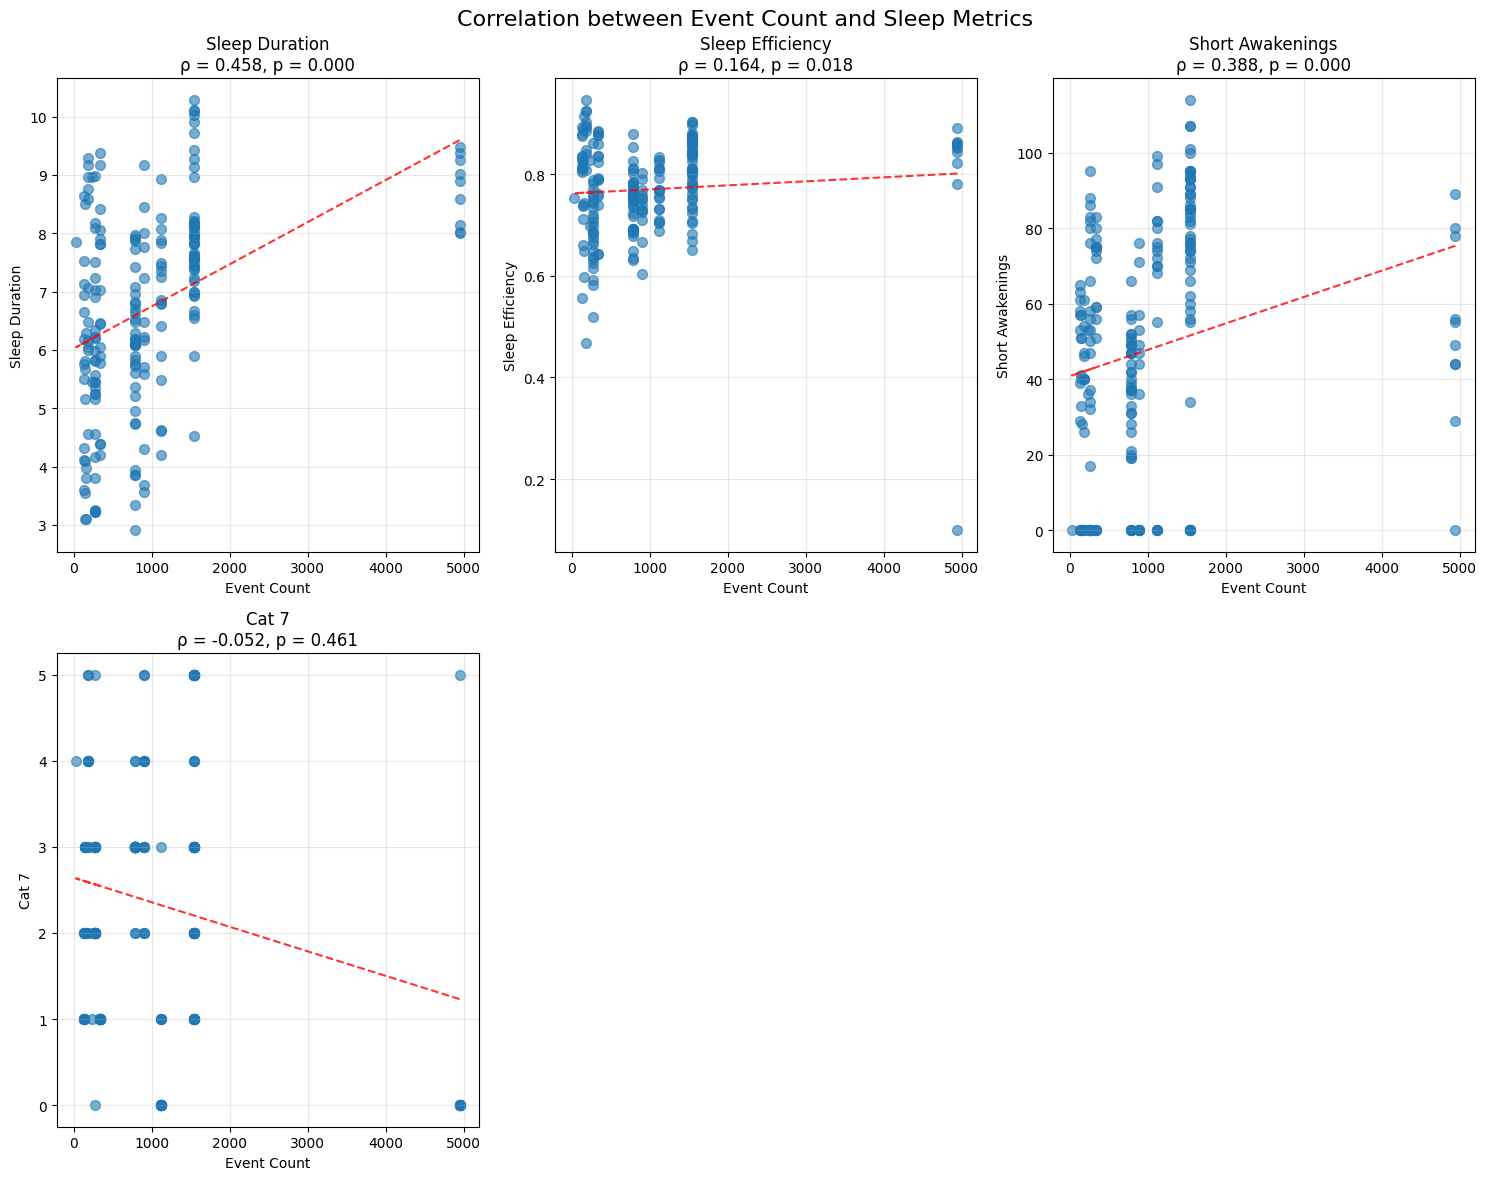

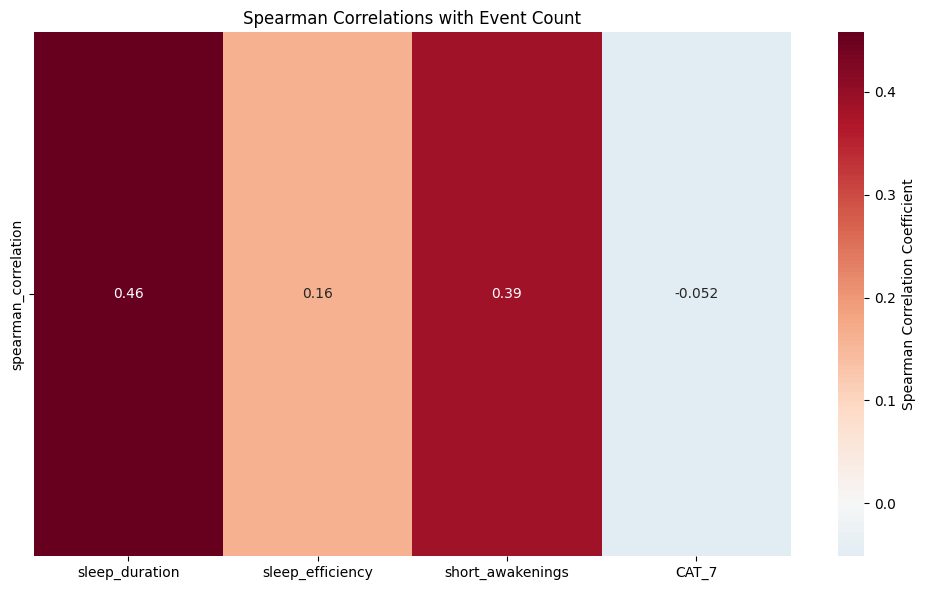


First few rows of merged data:
   Unnamed: 0        date      ID  sleep_duration  sleep_efficiency  \
0           0  2021-08-19  PRB003        9.375000          0.892061   
1           1  2021-08-20  PRB003        8.000000          0.843931   
2           2  2021-08-21  PRB003        8.141667          0.781674   
3           3  2021-08-22  PRB003        9.250000          0.864007   
4           4  2021-08-23  PRB003        8.891667          0.852427   

   short_awakenings  position_changes            timestamp  CAT_7  Score  \
0                78                13  2021-08-19 17:42:05      0      5   
1                56                11  2021-08-20 21:06:33      5     12   
2                80                13  2021-08-21 20:43:33      0      4   
3                44                 7  2021-08-22 22:38:41      0      9   
4                49                10  2021-08-23 22:18:53      0      7   

   event_count  
0         4945  
1         4945  
2         4945  
3         4945  

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import glob
from scipy.stats import pearsonr, spearmanr
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

def count_events_per_patient(events_folder_path):
    """
    Count the number of events for each patient from individual CSV files.
    
    Args:
        events_folder_path (str): Path to folder containing patient event CSV files
    
    Returns:
        dict: Dictionary with patient ID as key and event count as value
    """
    events_folder = Path(events_folder_path)
    event_counts = {}
    
    # Get all CSV files in the folder
    csv_files = glob.glob(str(events_folder / "*.csv"))
    
    for file_path in csv_files:
        # Extract patient ID from filename (assuming format like PRB001_osa.csv)
        filename = Path(file_path).name
        patient_id = filename.split('_')[0]  # Gets PRB001 from PRB001_osa.csv
        
        try:
            # Read the CSV file and count rows (events)
            df = pd.read_csv(file_path)
            event_count = len(df)
            event_counts[patient_id] = event_count
            print(f"Patient {patient_id}: {event_count} events")
        except Exception as e:
            print(f"Error reading {file_path}: {e}")
    
    return event_counts

def load_and_merge_data(events_folder_path, sleep_data_path):
    """
    Load event counts and sleep data, then merge them.
    
    Args:
        events_folder_path (str): Path to folder containing patient event CSV files
        sleep_data_path (str): Path to sleep metrics CSV file
    
    Returns:
        pd.DataFrame: Merged dataframe with event counts and sleep metrics
    """
    # Get event counts for each patient
    event_counts = count_events_per_patient(events_folder_path)
    
    # Load sleep data
    sleep_df = pd.read_csv(sleep_data_path)
    
    # Create event counts dataframe
    events_df = pd.DataFrame(list(event_counts.items()), 
                           columns=['ID', 'event_count'])
    
    # Merge the dataframes
    merged_df = pd.merge(sleep_df, events_df, on='ID', how='inner')
    
    print(f"Successfully merged data for {len(merged_df)} patients")
    return merged_df

def calculate_correlations(df, target_columns):
    """
    Calculate Pearson and Spearman correlations between event_count and target columns.
    
    Args:
        df (pd.DataFrame): Input dataframe
        target_columns (list): List of columns to correlate with event_count
    
    Returns:
        pd.DataFrame: Correlation results
    """
    correlations = []
    
    for col in target_columns:
        if col in df.columns and df[col].dtype in ['int64', 'float64']:
            # Remove NaN values for correlation calculation
            clean_data = df[['event_count', col]].dropna()
            
            if len(clean_data) > 1:
                pearson_corr, pearson_p = pearsonr(clean_data['event_count'], clean_data[col])
                spearman_corr, spearman_p = spearmanr(clean_data['event_count'], clean_data[col])
                
                correlations.append({
                    'variable': col,
                    'pearson_correlation': pearson_corr,
                    'pearson_p_value': pearson_p,
                    'spearman_correlation': spearman_corr,
                    'spearman_p_value': spearman_p,
                    'sample_size': len(clean_data)
                })
    
    return pd.DataFrame(correlations)

def create_correlation_plots(df, target_columns, figsize=(15, 12)):
    """
    Create scatter plots showing correlations between event count and sleep metrics.
    
    Args:
        df (pd.DataFrame): Input dataframe
        target_columns (list): List of columns to plot against event_count
        figsize (tuple): Figure size for the plots
    """
    # Filter out non-numeric columns
    numeric_columns = [col for col in target_columns if col in df.columns and df[col].dtype in ['int64', 'float64']]
    
    if not numeric_columns:
        print("No numeric columns found for plotting")
        return
    
    n_plots = len(numeric_columns)
    n_cols = 3
    n_rows = (n_plots + n_cols - 1) // n_cols
    
    fig, axes = plt.subplots(n_rows, n_cols, figsize=figsize)
    fig.suptitle('Correlation between Event Count and Sleep Metrics', fontsize=16, y=0.98)
    
    # Flatten axes array for easier indexing
    if n_rows == 1:
        axes = [axes] if n_plots == 1 else axes
    else:
        axes = axes.flatten()
    
    for i, col in enumerate(numeric_columns):
        ax = axes[i]
        
        # Remove NaN values for plotting
        clean_data = df[['event_count', col]].dropna()
        
        if len(clean_data) > 1:
            # Create scatter plot
            ax.scatter(clean_data['event_count'], clean_data[col], alpha=0.6, s=50)
            
            # Add trend line
            z = np.polyfit(clean_data['event_count'], clean_data[col], 1)
            p = np.poly1d(z)
            ax.plot(clean_data['event_count'], p(clean_data['event_count']), "r--", alpha=0.8)
            
            # Calculate Spearman correlation
            corr, p_val = spearmanr(clean_data['event_count'], clean_data[col])
            
            # Set labels and title
            ax.set_xlabel('Event Count')
            ax.set_ylabel(col.replace('_', ' ').title())
            ax.set_title(f'{col.replace("_", " ").title()}\nρ = {corr:.3f}, p = {p_val:.3f}')
            ax.grid(True, alpha=0.3)
        else:
            ax.text(0.5, 0.5, f'Insufficient data\nfor {col}', 
                   horizontalalignment='center', verticalalignment='center',
                   transform=ax.transAxes)
            ax.set_title(col.replace('_', ' ').title())
    
    # Hide unused subplots
    for i in range(n_plots, len(axes)):
        axes[i].set_visible(False)
    
    plt.tight_layout()
    plt.show()

def create_correlation_heatmap(corr_df):
    """
    Create a heatmap of Spearman correlation coefficients.
    
    Args:
        corr_df (pd.DataFrame): Dataframe with correlation results
    """
    if len(corr_df) == 0:
        print("No correlation data to plot")
        return
    
    fig, ax = plt.subplots(1, 1, figsize=(10, 6))
    
    # Spearman correlations only
    spearman_data = corr_df.set_index('variable')['spearman_correlation']
    sns.heatmap(spearman_data.to_frame().T, annot=True, cmap='RdBu_r', center=0, 
                ax=ax, cbar_kws={'label': 'Spearman Correlation Coefficient'})
    ax.set_title('Spearman Correlations with Event Count')
    ax.set_xlabel('')
    
    plt.tight_layout()
    plt.show()

def print_correlation_summary(corr_df):
    """
    Print a summary of Spearman correlation results.
    
    Args:
        corr_df (pd.DataFrame): Dataframe with correlation results
    """
    print("\n" + "="*60)
    print("SPEARMAN CORRELATION ANALYSIS SUMMARY")
    print("="*60)
    
    if len(corr_df) == 0:
        print("No correlations calculated.")
        return
    
    print(f"{'Variable':<25} {'Spearman ρ':<12} {'P-value':<12} {'N':<8}")
    print("-" * 60)
    
    for _, row in corr_df.iterrows():
        print(f"{row['variable']:<25} {row['spearman_correlation']:8.3f}    "
              f"{row['spearman_p_value']:8.3f}    {row['sample_size']:4.0f}")
    
    print("\nSignificant correlations (p < 0.05):")
    significant = corr_df[corr_df['spearman_p_value'] < 0.05]
    if len(significant) > 0:
        for _, row in significant.iterrows():
            print(f"  • {row['variable']}: Spearman ρ = {row['spearman_correlation']:.3f} (p = {row['spearman_p_value']:.3f})")
    else:
        print("  No significant correlations found.")

# Main analysis function
def analyze_sleep_events_correlation(events_folder_path, sleep_data_path):
    """
    Main function to perform complete correlation analysis.
    
    Args:
        events_folder_path (str): Path to folder containing patient event CSV files
        sleep_data_path (str): Path to sleep metrics CSV file
    """
    print("Starting Sleep Events Correlation Analysis")
    print("=" * 50)
    
    # Load and merge data
    df = load_and_merge_data(events_folder_path, sleep_data_path)
    
    # Define target columns for correlation analysis
    target_columns = ['sleep_duration', 'sleep_efficiency', 'short_awakenings', 'CAT_7']
    
    # Calculate correlations
    corr_results = calculate_correlations(df, target_columns)
    
    # Print summary
    print_correlation_summary(corr_results)
    
    # Create plots
    create_correlation_plots(df, target_columns)
    create_correlation_heatmap(corr_results)
    
    return df, corr_results


# Example usage:
if __name__ == "__main__":
    # Set your paths here
    events_folder = "./smile_osa_cnn"  # Folder containing PRB001_osa.csv, etc.
    sleep_data_file = "./all_sleep_metrics_cats.csv"  # Your main sleep metrics file
    
    # Run the analysis
    data, correlations = analyze_sleep_events_correlation(events_folder, sleep_data_file)
    
    # You can also access the merged data for further analysis
    print("\nFirst few rows of merged data:")
    print(data.head())
    
    # Save results if needed
    # correlations.to_csv('correlation_results.csv', index=False)
    # data.to_csv('merged_sleep_events_data.csv', index=False)

Starting Sleep Events Correlation Analysis
Using normalized event rates based on raw data availability
Raw data search pattern: {patient_id}*/Respeck/*.csv
Found 68 raw files for patient PRB005
Total raw data points for PRB005: 34593249
Sleep-time data points for PRB005: 13376342
Patient PRB005: 170 events, normalized rate: 0.013 events/1000 data points
Found 65 raw files for patient PRB202
Total raw data points for PRB202: 29168622
Sleep-time data points for PRB202: 12111386
Patient PRB202: 183 events, normalized rate: 0.015 events/1000 data points
Found 80 raw files for patient PRB107
Total raw data points for PRB107: 21236326
Sleep-time data points for PRB107: 10495899
Patient PRB107: 152 events, normalized rate: 0.014 events/1000 data points
Found 70 raw files for patient PRB203
Total raw data points for PRB203: 65842713
Sleep-time data points for PRB203: 35741659
Patient PRB203: 1540 events, normalized rate: 0.043 events/1000 data points
Found 4 raw files for patient PRB004
Total 

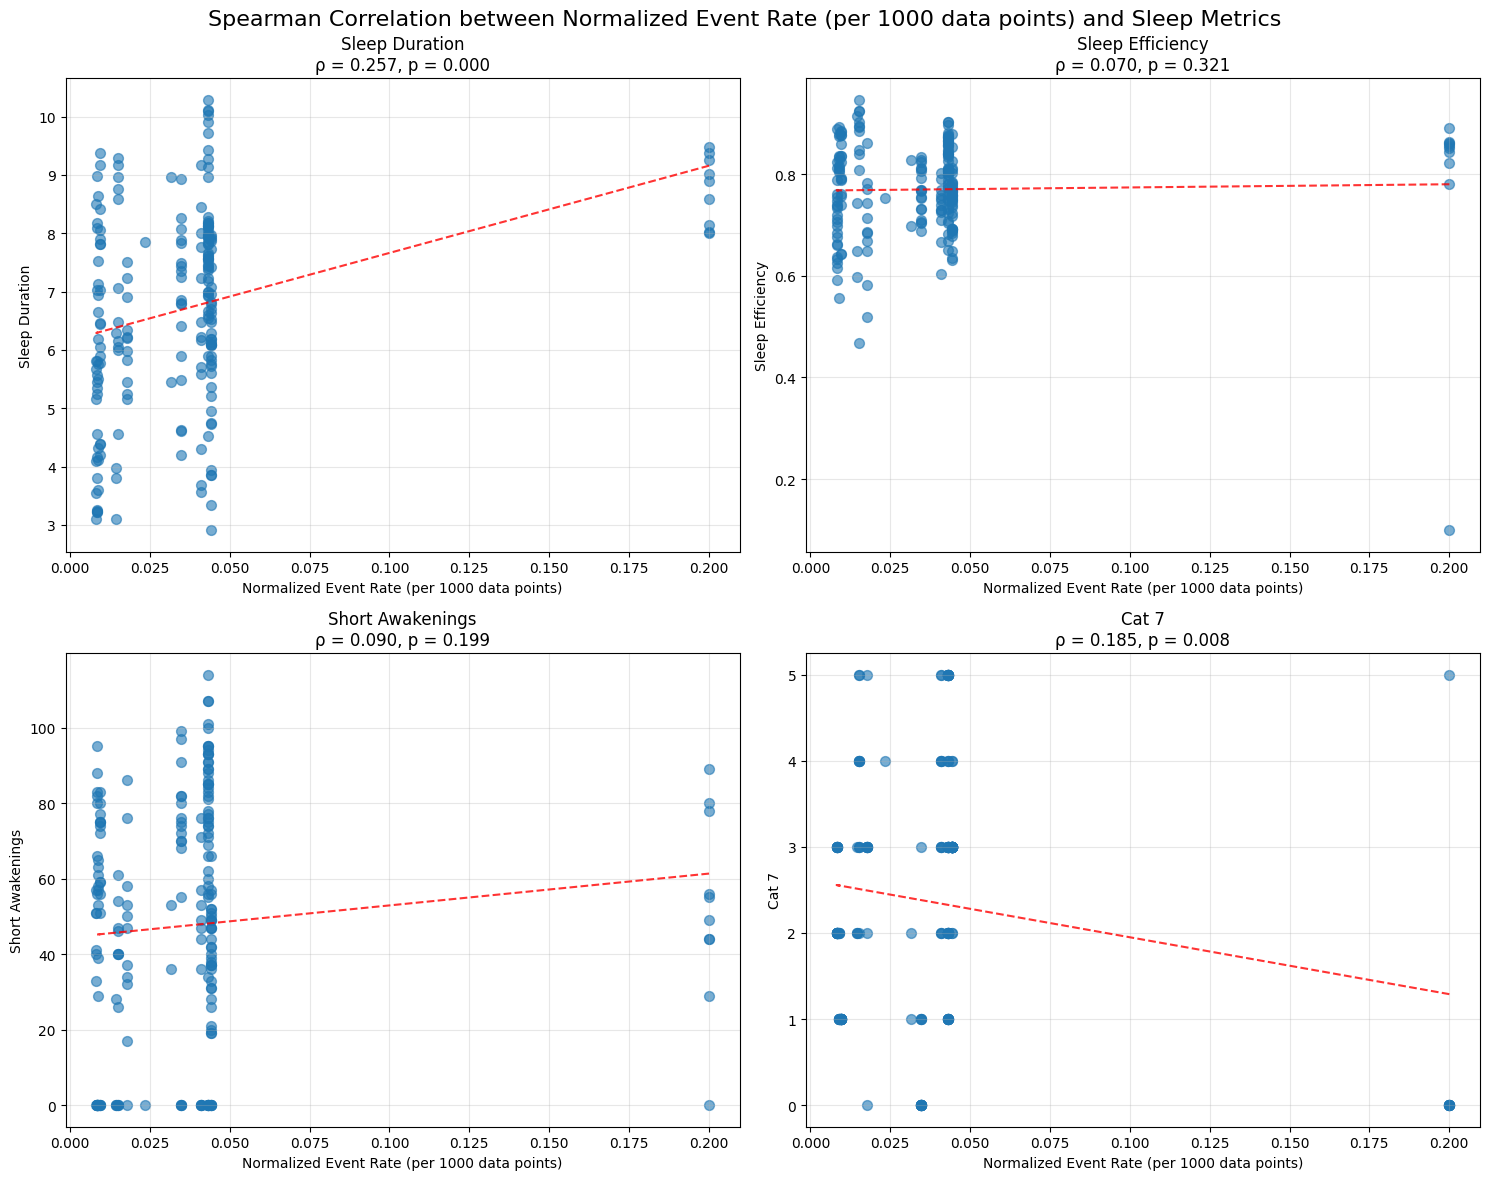

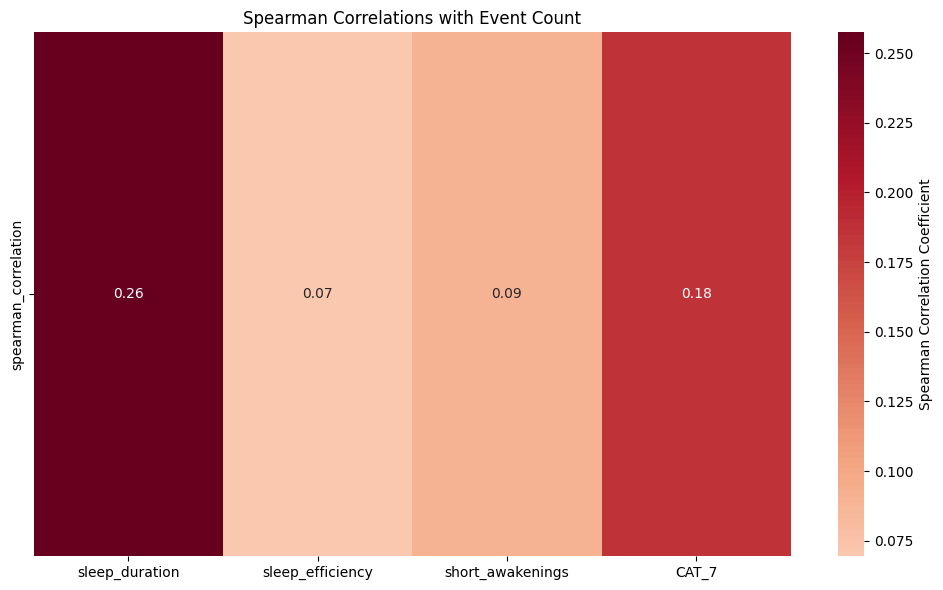


First few rows of merged data:
   Unnamed: 0        date      ID  sleep_duration  sleep_efficiency  \
0           0  2021-08-19  PRB003        9.375000          0.892061   
1           1  2021-08-20  PRB003        8.000000          0.843931   
2           2  2021-08-21  PRB003        8.141667          0.781674   
3           3  2021-08-22  PRB003        9.250000          0.864007   
4           4  2021-08-23  PRB003        8.891667          0.852427   

   short_awakenings  position_changes            timestamp  CAT_7  Score  \
0                78                13  2021-08-19 17:42:05      0      5   
1                56                11  2021-08-20 21:06:33      5     12   
2                80                13  2021-08-21 20:43:33      0      4   
3                44                 7  2021-08-22 22:38:41      0      9   
4                49                10  2021-08-23 22:18:53      0      7   

   normalized_event_rate  
0               0.200051  
1               0.200051  
2  

In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import glob
from scipy.stats import pearsonr, spearmanr
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

def count_events_per_patient(events_folder_path, data_root_folder=None):
    """
    Count the number of events for each patient from individual CSV files.
    Optionally normalize by raw data points if data_root_folder is provided.
    
    Args:
        events_folder_path (str): Path to folder containing patient event CSV files
        data_root_folder (str): Optional root path containing patient data folders
    
    Returns:
        dict: Dictionary with patient ID as key and event count/normalized rate as value
    """
    import pytz
    
    events_folder = Path(events_folder_path)
    event_counts = {}
    
    # Get all CSV files in the folder
    csv_files = glob.glob(str(events_folder / "*.csv"))
    
    for file_path in csv_files:
        # Extract patient ID from filename (assuming format like PRB001_osa.csv)
        filename = Path(file_path).name
        patient_id = filename.split('_')[0]  # Gets PRB001 from PRB001_osa.csv
        
        try:
            # Read the CSV file and count events
            df = pd.read_csv(file_path)
            event_count = len(df)
            
            # If data root folder is provided, normalize by data availability
            if data_root_folder:
                normalized_rate = calculate_normalized_event_rate(patient_id, data_root_folder, event_count)
                event_counts[patient_id] = normalized_rate
                print(f"Patient {patient_id}: {event_count} events, normalized rate: {normalized_rate:.3f} events/1000 data points")
            else:
                event_counts[patient_id] = event_count
                print(f"Patient {patient_id}: {event_count} events")
                
        except Exception as e:
            print(f"Error reading {file_path}: {e}")
    
    return event_counts

def calculate_normalized_event_rate(patient_id, data_root_folder, event_count):
    """
    Calculate normalized event rate for a patient based on raw data availability.
    
    Args:
        patient_id (str): Patient ID (e.g., 'PRB001')
        data_root_folder (str): Root path containing patient folders
        event_count (int): Number of events for this patient
    
    Returns:
        float: Normalized event rate (events per 1000 data points)
    """
    import pytz
    import os
    
    try:
        # Find raw data files for this patient using the specified pattern
        raw_search_pattern = os.path.join(data_root_folder, f"{patient_id}*/Respeck/*.csv")
        raw_files = glob.glob(raw_search_pattern)
        
        if not raw_files:
            print(f"No raw files found for patient {patient_id} in pattern {raw_search_pattern}, using raw event count")
            return event_count
        
        print(f"Found {len(raw_files)} raw files for patient {patient_id}")
        
        # Read and combine raw data files
        raw_df_list = []
        for file in raw_files:
            try:
                df = pd.read_csv(file, on_bad_lines='skip', usecols=['interpolatedPhoneTimestamp'])
                if not df.empty:
                    raw_df_list.append(df)
            except Exception as e:
                print(f"Error reading raw file {file}: {e}")
                continue
        
        if not raw_df_list:
            print(f"All raw data files were empty for patient {patient_id}, using raw event count")
            return event_count
        
        # Combine all raw data
        raw_df = pd.concat(raw_df_list, ignore_index=True)
        print(f"Total raw data points for {patient_id}: {len(raw_df)}")
        
        # Convert timestamps and filter for 9pm-10am
        scotland_tz = pytz.timezone('Europe/London')
        raw_df['datetime'] = pd.to_datetime(raw_df['interpolatedPhoneTimestamp'], 
                                          unit='ms', errors='coerce', utc=True).dt.tz_convert(scotland_tz)
        raw_df.dropna(subset=['datetime'], inplace=True)
        raw_df['hour'] = raw_df['datetime'].dt.hour
        
        # Count data points in sleep hours (9pm-10am)
        nightly_hours = [21, 22, 23, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
        sleep_time_data = raw_df[raw_df['hour'].isin(nightly_hours)]
        total_sleep_data_points = len(sleep_time_data)
        
        print(f"Sleep-time data points for {patient_id}: {total_sleep_data_points}")
        
        if total_sleep_data_points == 0:
            print(f"No sleep-time data points found for patient {patient_id}, using raw event count")
            return event_count
        
        # Calculate normalized rate (events per 1000 data points)
        normalized_rate = (event_count / total_sleep_data_points) * 1000
        return normalized_rate
        
    except Exception as e:
        print(f"Error calculating normalized rate for patient {patient_id}: {e}")
        return event_count

def load_and_merge_data(events_folder_path, sleep_data_path, data_root_folder=None):
    """
    Load event counts and sleep data, then merge them.
    
    Args:
        events_folder_path (str): Path to folder containing patient event CSV files
        sleep_data_path (str): Path to sleep metrics CSV file
        data_root_folder (str): Optional root path containing patient data folders for normalization
    
    Returns:
        pd.DataFrame: Merged dataframe with event counts/rates and sleep metrics
    """
    # Get event counts for each patient (normalized if data root folder provided)
    event_counts = count_events_per_patient(events_folder_path, data_root_folder)
    
    # Load sleep data
    sleep_df = pd.read_csv(sleep_data_path)
    
    # Create event counts dataframe
    if data_root_folder:
        events_df = pd.DataFrame(list(event_counts.items()), 
                               columns=['ID', 'normalized_event_rate'])
    else:
        events_df = pd.DataFrame(list(event_counts.items()), 
                               columns=['ID', 'event_count'])
    
    # Merge the dataframes
    merged_df = pd.merge(sleep_df, events_df, on='ID', how='inner')
    
    print(f"Successfully merged data for {len(merged_df)} patients")
    return merged_df

def calculate_correlations(df, target_columns):
    """
    Calculate Pearson and Spearman correlations between event_count/normalized_event_rate and target columns.
    
    Args:
        df (pd.DataFrame): Input dataframe
        target_columns (list): List of columns to correlate with event data
    
    Returns:
        pd.DataFrame: Correlation results
    """
    correlations = []
    
    # Determine the event column name
    event_col = 'normalized_event_rate' if 'normalized_event_rate' in df.columns else 'event_count'
    
    for col in target_columns:
        if col in df.columns and df[col].dtype in ['int64', 'float64']:
            # Remove NaN values for correlation calculation
            clean_data = df[[event_col, col]].dropna()
            
            if len(clean_data) > 1:
                pearson_corr, pearson_p = pearsonr(clean_data[event_col], clean_data[col])
                spearman_corr, spearman_p = spearmanr(clean_data[event_col], clean_data[col])
                
                correlations.append({
                    'variable': col,
                    'pearson_correlation': pearson_corr,
                    'pearson_p_value': pearson_p,
                    'spearman_correlation': spearman_corr,
                    'spearman_p_value': spearman_p,
                    'sample_size': len(clean_data)
                })
    
    return pd.DataFrame(correlations)

def create_correlation_plots(df, target_columns, figsize=(15, 12)):
    """
    Create scatter plots showing correlations between event count/rate and sleep metrics.
    
    Args:
        df (pd.DataFrame): Input dataframe
        target_columns (list): List of columns to plot against event data
        figsize (tuple): Figure size for the plots
    """
    # Filter out non-numeric columns
    numeric_columns = [col for col in target_columns if col in df.columns and df[col].dtype in ['int64', 'float64']]
    
    if not numeric_columns:
        print("No numeric columns found for plotting")
        return
    
    # Determine the event column name and label
    event_col = 'normalized_event_rate' if 'normalized_event_rate' in df.columns else 'event_count'
    x_label = 'Normalized Event Rate (per 1000 data points)' if event_col == 'normalized_event_rate' else 'Event Count'
    
    n_plots = len(numeric_columns)
    n_cols = 2
    n_rows = (n_plots + n_cols - 1) // n_cols
    
    fig, axes = plt.subplots(n_rows, n_cols, figsize=figsize)
    fig.suptitle(f'Spearman Correlation between {x_label} and Sleep Metrics', fontsize=16, y=0.98)
    
    # Flatten axes array for easier indexing
    if n_rows == 1:
        axes = [axes] if n_plots == 1 else axes
    else:
        axes = axes.flatten()
    
    for i, col in enumerate(numeric_columns):
        ax = axes[i]
        
        # Remove NaN values for plotting
        clean_data = df[[event_col, col]].dropna()
        
        if len(clean_data) > 1:
            # Create scatter plot
            ax.scatter(clean_data[event_col], clean_data[col], alpha=0.6, s=50)
            
            # Add trend line
            z = np.polyfit(clean_data[event_col], clean_data[col], 1)
            p = np.poly1d(z)
            ax.plot(clean_data[event_col], p(clean_data[event_col]), "r--", alpha=0.8)
            
            # Calculate Spearman correlation
            corr, p_val = spearmanr(clean_data[event_col], clean_data[col])
            
            # Set labels and title
            ax.set_xlabel(x_label)
            ax.set_ylabel(col.replace('_', ' ').title())
            ax.set_title(f'{col.replace("_", " ").title()}\nρ = {corr:.3f}, p = {p_val:.3f}')
            ax.grid(True, alpha=0.3)
        else:
            ax.text(0.5, 0.5, f'Insufficient data\nfor {col}', 
                   horizontalalignment='center', verticalalignment='center',
                   transform=ax.transAxes)
            ax.set_title(col.replace('_', ' ').title())
    
    # Hide unused subplots
    for i in range(n_plots, len(axes)):
        axes[i].set_visible(False)
    
    plt.tight_layout()
    plt.show()

def create_correlation_heatmap(corr_df):
    """
    Create a heatmap of Spearman correlation coefficients.
    
    Args:
        corr_df (pd.DataFrame): Dataframe with correlation results
    """
    if len(corr_df) == 0:
        print("No correlation data to plot")
        return
    
    fig, ax = plt.subplots(1, 1, figsize=(10, 6))
    
    # Spearman correlations only
    spearman_data = corr_df.set_index('variable')['spearman_correlation']
    sns.heatmap(spearman_data.to_frame().T, annot=True, cmap='RdBu_r', center=0, 
                ax=ax, cbar_kws={'label': 'Spearman Correlation Coefficient'})
    ax.set_title('Spearman Correlations with Event Count')
    ax.set_xlabel('')
    
    plt.tight_layout()
    plt.show()

def print_correlation_summary(corr_df):
    """
    Print a summary of Spearman correlation results.
    
    Args:
        corr_df (pd.DataFrame): Dataframe with correlation results
    """
    print("\n" + "="*60)
    print("SPEARMAN CORRELATION ANALYSIS SUMMARY")
    print("="*60)
    
    if len(corr_df) == 0:
        print("No correlations calculated.")
        return
    
    print(f"{'Variable':<25} {'Spearman ρ':<12} {'P-value':<12} {'N':<8}")
    print("-" * 60)
    
    for _, row in corr_df.iterrows():
        print(f"{row['variable']:<25} {row['spearman_correlation']:8.3f}    "
              f"{row['spearman_p_value']:8.3f}    {row['sample_size']:4.0f}")
    
    print("\nSignificant correlations (p < 0.05):")
    significant = corr_df[corr_df['spearman_p_value'] < 0.05]
    if len(significant) > 0:
        for _, row in significant.iterrows():
            print(f"  • {row['variable']}: Spearman ρ = {row['spearman_correlation']:.3f} (p = {row['spearman_p_value']:.3f})")
    else:
        print("  No significant correlations found.")

# Main analysis function
def analyze_sleep_events_correlation(events_folder_path, sleep_data_path, data_root_folder=None):
    """
    Main function to perform complete correlation analysis.
    
    Args:
        events_folder_path (str): Path to folder containing patient event CSV files
        sleep_data_path (str): Path to sleep metrics CSV file
        data_root_folder (str): Optional root path containing patient data folders for normalization
    """
    print("Starting Sleep Events Correlation Analysis")
    print("=" * 50)
    
    if data_root_folder:
        print("Using normalized event rates based on raw data availability")
        print("Raw data search pattern: {patient_id}*/Respeck/*.csv")
    else:
        print("Using raw event counts")
    
    # Load and merge data
    df = load_and_merge_data(events_folder_path, sleep_data_path, data_root_folder)
    
    # Define target columns for correlation analysis
    target_columns = ['sleep_duration', 'sleep_efficiency', 'short_awakenings', 'CAT_7']
    
    # Calculate correlations
    corr_results = calculate_correlations(df, target_columns)
    
    # Print summary
    print_correlation_summary(corr_results)
    
    # Create plots
    create_correlation_plots(df, target_columns)
    create_correlation_heatmap(corr_results)
    
    return df, corr_results


# Example usage:
if __name__ == "__main__":
    # Set your paths here
    events_folder = "./smile_osa_cnn"  # Folder containing PRB001_osa.csv, etc.
    sleep_data_file = "./all_sleep_metrics_cats.csv"  # Your main sleep metrics file
    raw_data_folder = "../../data/SMILE"
    # Run the analysis
    data, correlations = analyze_sleep_events_correlation(events_folder, sleep_data_file, raw_data_folder)
    
    # You can also access the merged data for further analysis
    print("\nFirst few rows of merged data:")
    print(data.head())
    
    # Save results if needed
    # correlations.to_csv('correlation_results.csv', index=False)
    # data.to_csv('merged_sleep_events_data.csv', index=False)